# Tarea

Utilizando la base de datos de encuestas CASEN 2017:

1. Realizar un análisis exploratorio de los datos.
2. Aplicar tres de los algoritmos desarrollados en clases justificando su elección.
3. Aplicar evaluación de cada uno de ellos con medidas vistas en clases y cross validation.
4. Seleccionar el mejor método para el problema presentado.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from numpy import average
from multiscorer import MultiScorer
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score    

warnings.filterwarnings("ignore")

## CASEN 2017
-----

In [2]:
df_casen_2017 = pd.read_spss('Casen 2017.sav')

------

Para facilitar un primer vistazo de la información, transformaremos *folio* y *o* a entero, lo que nos entrega la llave única de cada registro.

------

In [3]:
df_casen_2017 = df_casen_2017.astype({'folio':'int','o':'int'})
df_casen_2017.head()

,folio,o,id_vivienda,hogar,region,provincia,comuna,zona,expr,expc,...,hh_d_estado,hh_d_servbas,hh_d_entorno,hh_d_accesi,hh_d_medio,hh_d_appart,hh_d_tsocial,hh_d_seg,pobreza_multi_4d,pobreza_multi_5d
0,110110020201,1,1.101100e+09,1.0,Región de Tarapacá,Iquique,Iquique,Urbano,39.0,33.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN
1,110110020301,1,1.101100e+09,1.0,Región de Tarapacá,Iquique,Iquique,Urbano,39.0,33.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pobre,Pobre
2,110110020401,1,1.101100e+09,1.0,Región de Tarapacá,Iquique,Iquique,Urbano,39.0,33.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN
3,110110020401,2,1.101100e+09,1.0,Región de Tarapacá,Iquique,Iquique,Urbano,39.0,33.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN
4,110110020501,1,1.101100e+09,1.0,Región de Tarapacá,Iquique,Iquique,Urbano,39.0,33.0,...,1.0,1.0,1.0,0.0,1.0,NaN,1.0,0.0,No pobre,NaN


In [4]:
df_casen_2017.shape

(216439, 804)

## Variables utilizadas

------

     
 - **Variable Dependiente**:
     - *pobreza*: Situación de pobreza por ingresos (Variable categórica)  
       
       
 - **Variables Independiente**:
     - *sexo*: Sexo de quien responde la encuesta (Variable categórica)
     - *edad*: Edad de quien responde la encuesta (Variable numérica discreta)
     - *ecivil*: Estado civil de quien responde la encuesta (Variable categórica)
     - *educ*: Escolaridad de quien responde la encuesta (Variable ordinal)
     - *depen*: Tipo de dependencia del colegio al que asistio quien responde la encuesta (Variable categórica)
     - *activ*: Categoría de ocupación de quien responde la encuesta (Variable categórica)
     - *indmat*: Indicador de materialidad de la vivienda de quien responde la encuesta (Variable categórica)
     - *indsan*: Indicador de saneamiento de la vivienda de quien responde la encuesta (Variable categórica)
     - *calglobviv*: Calidad global de la vivienda de quien responde la encuesta (Variable categórica)
     - *hacinamiento*: Nivel de hacinamiento de la vivienda de quien responde la encuesta (Variable categórica)
     - *s12*: Sistema previsional de salud de quien responde la encuesta (Variable categórica)
     - *o16*: Tipo de contrato de quien responde la encuesta (Variable categórica)
     - *o1*: Flag de trabajo la semana anterior de quien responde la encuesta (Variable categórica)
     - *oficio1*: Ocupación u oficio de quien responde la encuesta (Variable categórica)
     - *ytot*: Salario de quien responde la encuesta (Variable numérica discreta)
       
       
El objetivo de este notebook es poder clasificar la categoría de pobreza de una persona en base a las variables anteriores (12 de ellas categórica, 1 ordinal y 2 de ellas numérica discreta), utilizando 3 modelos diferentes. Posteriormente se compararan las estimaciones de los modelos en base a las medidas de performance vistas en clases y se uti.  
  
Antes de comenzar con el modelamiento, se realiza un EDA para limpiar nuestra base de datos.

------

In [5]:
dep_var = ['pobreza']
indep_var = ['sexo','edad','ecivil','educ','depen','activ','indmat','indsan','calglobviv','hacinamiento','s12','o16','o1','oficio1','ytot']
var = ['pobreza','sexo','edad','ecivil','educ','depen','activ','indmat','indsan','calglobviv','hacinamiento','s12','o16','o1','oficio1','ytot']

df_var = df_casen_2017[var].rename(columns = {'s12': 'prevision_salud', 'o16': 'tipo_contrato', 'o1': 'trabajo_flag', 'oficio1': 'oficio', 'ytot': 'salario' }, inplace = False)
df_var

,pobreza,sexo,edad,ecivil,educ,depen,activ,indmat,indsan,calglobviv,hacinamiento,prevision_salud,tipo_contrato,trabajo_flag,oficio,salario
0,No pobres,Mujer,56.0,Soltero(a),M. Hum. Completa,NaN,Ocupados,Vivienda Aceptable,Deficitario,Recuperable,"Sin hacinamiento (2,49 y menos)",No sabe,NaN,Sí,Trabajadores no calificado,250000.0
1,No pobres,Mujer,21.0,Soltero(a),Básica Incom.,NaN,Ocupados,Vivienda Aceptable,Aceptable,Aceptable,"Sin hacinamiento (2,49 y menos)",Ninguno (Particular),Plazo fijo,Sí,Trabajadores no calificado,211091.0
2,No pobres,Hombre,24.0,Conviviente o pareja sin acuerdo de unión civil,M. Hum. Completa,NaN,Ocupados,Vivienda Aceptable,Aceptable,Aceptable,"Sin hacinamiento (2,49 y menos)",No sabe,Plazo fijo,Sí,Trabajadores de los servicios y vendedores de ...,281750.0
3,No pobres,Hombre,28.0,Conviviente o pareja sin acuerdo de unión civil,M. Hum. Completa,NaN,Ocupados,Vivienda Aceptable,Aceptable,Aceptable,"Sin hacinamiento (2,49 y menos)",No sabe,Plazo fijo,Sí,Trabajadores de los servicios y vendedores de ...,311750.0
4,No pobres,Hombre,26.0,Casado(a),Técnico Nivel Superior Completo,NaN,Ocupados,Vivienda Aceptable,Deficitario,Recuperable,"Sin hacinamiento (2,49 y menos)",Sistema Público FONASA Grupo B,Plazo indefinido,No,Trabajadores no calificado,341667.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216434,No pobres,Mujer,64.0,Casado(a),Básica Incom.,NaN,Inactivos,Vivienda Recuperable,Deficitario,Recuperable,"Sin hacinamiento (2,49 y menos)",Sistema Público FONASA Grupo A,NaN,No,NaN,104646.0
216435,No pobres,Hombre,64.0,Casado(a),Básica Incom.,NaN,Ocupados,Vivienda Recuperable,Deficitario,Recuperable,"Sin hacinamiento (2,49 y menos)",Sistema Público FONASA Grupo A,NaN,Sí,Trabajadores no calificado,304646.0
216436,No pobres,Hombre,66.0,Casado(a),M. Hum. Completa,NaN,Inactivos,Vivienda Recuperable,Deficitario,Recuperable,"Sin hacinamiento (2,49 y menos)",Sistema Público FONASA Grupo A,NaN,No,NaN,90000.0
216437,No pobres,Mujer,60.0,Casado(a),Básica Incom.,NaN,Ocupados,Vivienda Recuperable,Deficitario,Recuperable,"Sin hacinamiento (2,49 y menos)",Sistema Público FONASA Grupo A,NaN,Sí,Agricultores y trabajadores calificados agrope...,250000.0


## Limpieza

------

Para facilitar el análisis se toman dos decisiones de limpieza de datos antes de cualquier análisis gráfico:

1. Imputaremos los valores nulos categóricos de nuestra base de datos con el string 'Vacío' para que tengamos completitud en todas las celdas.
2. Se le aplica logaritmo natural a la columna salario para que los outliers no afecten tanto nuestros modelos.
3. Se eliminaran los nulos de nuestra variable salario y edad.

------

In [6]:
df_not_nan = df_var[(df_var['salario']>=0) & (df_var['edad']>=0) & (df_var['pobreza'].notnull())]

c_var = ['educ','depen','activ','tipo_contrato','trabajo_flag','oficio']
for s_var in c_var:
    df_not_nan[s_var] = df_not_nan[s_var].cat.add_categories('Vacío')

df_not_nan[c_var] = df_not_nan[c_var].fillna('Vacío')
df_not_nan["salario"] = np.log2(df_not_nan['salario']+1)

In [7]:
list(df_var['educ'].unique())

['M. Hum. Completa',
 'Básica Incom.',
 'Técnico Nivel Superior Completo',
 'Sin Educ. Formal',
 'M. Hum. Incompleta',
 'M. Téc Completa',
 'Básica Compl.',
 'Profesional Incompleto',
 'Profesional Completo',
 'M. Téc. Prof. Incompleta',
 'Técnico Nivel Superior Incompleta',
 'Postgrado Completo',
 'Postgrado Incompleto',
 'NS/NR']

------

Dado que existe una especie de orden en la variable de educación máxima (Por esto la taggeamos como ordinal) se realiza un parseo de esta a sus valores, dejando como valor 999 la NS/NR. Todo esto para quitar los registros que tengan NS/NR como valor de educación, y que nuestra ordinalidad tenga sentido.

------

In [8]:
def education_parse(level):
    aux_dict = {
        'Sin Educ. Formal'                                 : 1,
        'Básica Incom.'                                    : 2,
        'Básica Compl.'                                    : 3,
        'M. Téc. Prof. Incompleta'                         : 4,
        'M. Hum. Incompleta'                               : 5,
        'M. Téc Completa'                                  : 6,
        'M. Hum. Completa'                                 : 7,
        'Técnico Nivel Superior Incompleta'                : 8,
        'Profesional Incompleto'                           : 9,
        'Técnico Nivel Superior Completo'                  : 10,
        'Profesional Completo'                             : 11,
        'Postgrado Incompleto'                             : 12,
        'Postgrado Completo'                               : 13,
        'NS/NR'                                            : 999,
        'Vacío'                                            : 999
    }
    return aux_dict[level]

In [9]:
df_not_nan['ordinal_education'] = df_not_nan['educ'].apply(education_parse)
df_not_nan = df_not_nan[df_not_nan['ordinal_education']!=999].astype({'edad':'int'})
df_not_nan.dtypes

pobreza              category
sexo                 category
edad                    int64
ecivil               category
educ                 category
depen                category
activ                category
indmat               category
indsan               category
calglobviv           category
hacinamiento         category
prevision_salud      category
tipo_contrato        category
trabajo_flag         category
oficio               category
salario               float64
ordinal_education       int64
dtype: object

In [10]:
df_not_nan.isna().sum().sum()

0

## Análisis exploratorio

------

Teniendo ya nuestra base pseudo limpia de outliers y con cada campo ya a medio trabajar, procederemos a realizar boxplots de todas nuestras variables para analizar si existe algun patrón que podamos notar a simple vista. 

------

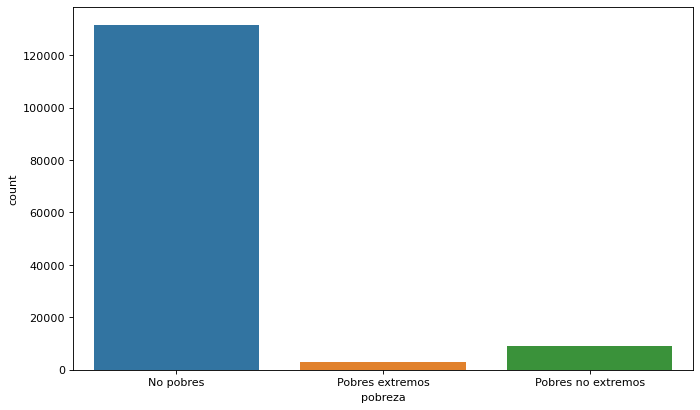

In [11]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="pobreza", data=df_not_nan)
plt.show()

---

Lo primero que notamos es que nuestros datos están completamente desbalanceados, siendo la gran mayoría de la categoría no pobres. Este desbalanceo podría impactar en los modelos causando un sobreajuste, por lo que luego de seleccionar las variables a utilizar habría que utilizar alguna técnica de balanceo antes de cualquier modelo, para asi evitar un overfitting y poder generalizar nuestro resultado.

---

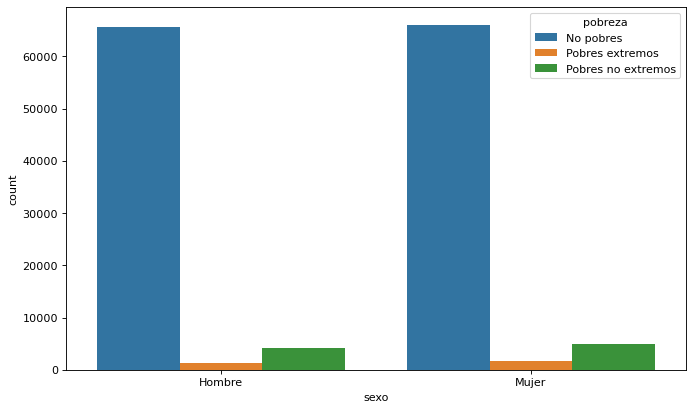

In [12]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="sexo", hue="pobreza", data=df_not_nan)
plt.show()

---

Si bien a priori la variable sexo parece distribuida de manera similar, existe un pequeño diferencial que nos indica que hay más mujeres que hombres en las categorías de pobreza, y quizás existan más diferencias si segmentaramos por más variables, por lo que usaremos la dimensión sexo en nuestro modelo.

---

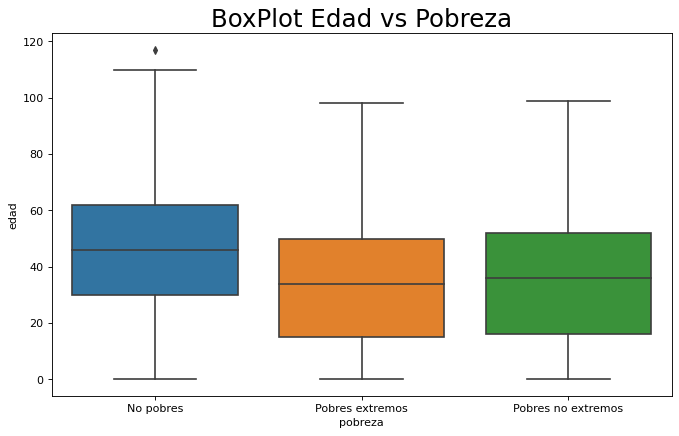

In [13]:
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.boxplot(x='pobreza', y='edad', data=df_not_nan, notch=False)

# Add N Obs inside boxplot (optional)
def add_n_obs(df,group_col,y):
    medians_dict = {grp[0]:grp[1][y].median() for grp in df.groupby(group_col)}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    n_obs = df.groupby(group_col)[y].size().values
    for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
        plt.text(x, medians_dict[xticklabel]*1.01, "#obs : "+str(n_ob), horizontalalignment='center', fontdict={'size':14}, color='white')

# Decoration
plt.title('BoxPlot Edad vs Pobreza', fontsize=22)
plt.show()

---

La dimensión edad nos entrega un primer insight importante, el que nos dice que el promedio de edad de los no pobres es mayor que las categorías de pobreza, incluso mostrando que los valores superiores se encuentran en la no pobreza. Esta variable también será utilizada en nuestro modelo.

---

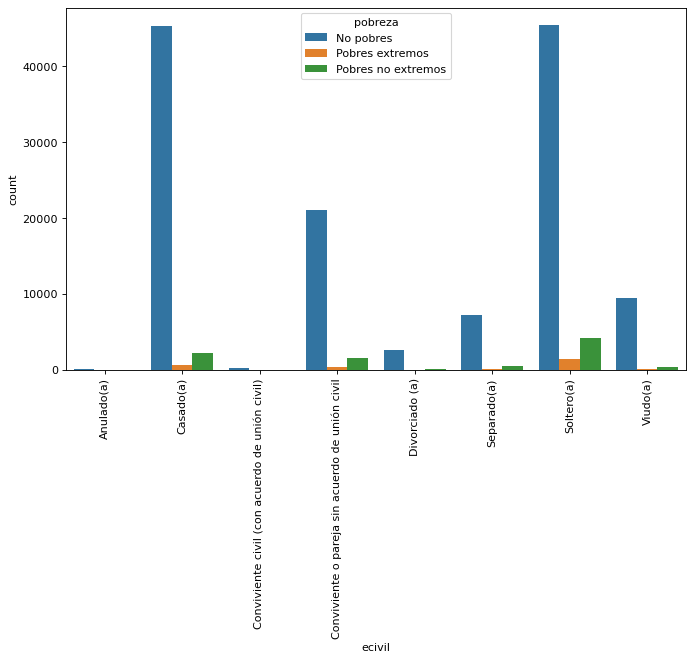

In [14]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="ecivil", hue="pobreza", data=df_not_nan)
plt.xticks(rotation=90)
plt.show()

---

Podemos notar que la pobreza porcentualmente se encuentra en mayor medida en las personas solteras en comparación a las casadas, por lo que esta variable podría entregarnos información relevante a la hora de clasificar. Será utilizada en nuestros modelos.

---

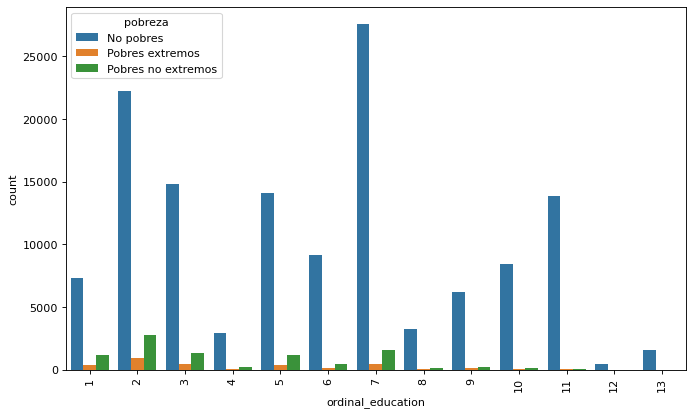

In [15]:
plt.figure(figsize=(10,6), dpi= 80)

sns.countplot(x="ordinal_education", hue="pobreza", data=df_not_nan)
plt.xticks(rotation=90)
plt.show()

---

Es clara la disminución del conteo en las categorías de pobreza a medida crece el nivel de educación, por lo que es importante considerar esta variable ordinal en los clasificadores.

---

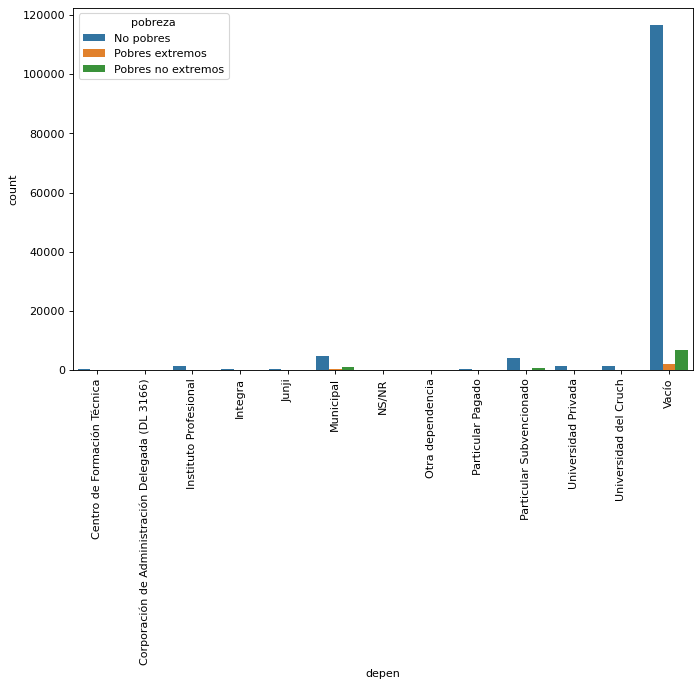

In [16]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="depen", hue="pobreza", data=df_not_nan)
plt.xticks(rotation=90)
plt.show()

---

Dada la gran cantidad de registros que venían vacíos dentro de esta dimensión, se decide dejarla fuera de los modelos.

---

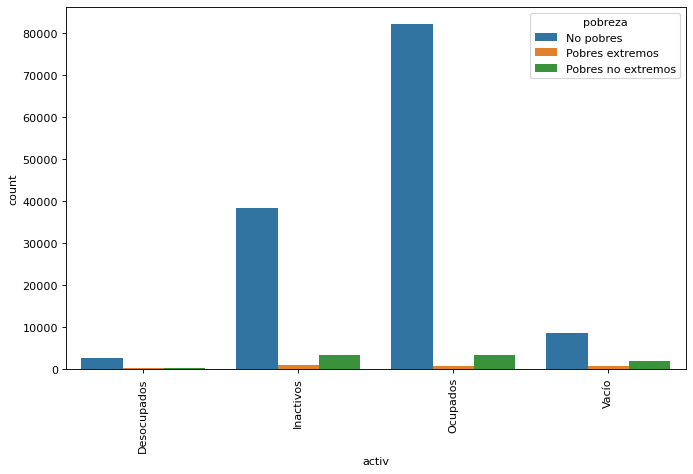

In [17]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="activ", hue="pobreza", data=df_not_nan)
plt.xticks(rotation=90)
plt.show()

---

Es visible que porcentualmente la pobreza se encuentra en mayor medida dentro de la categoría inactivos, por lo que se decide utilizar esta variable dentro de los modelos de clasificación.

---

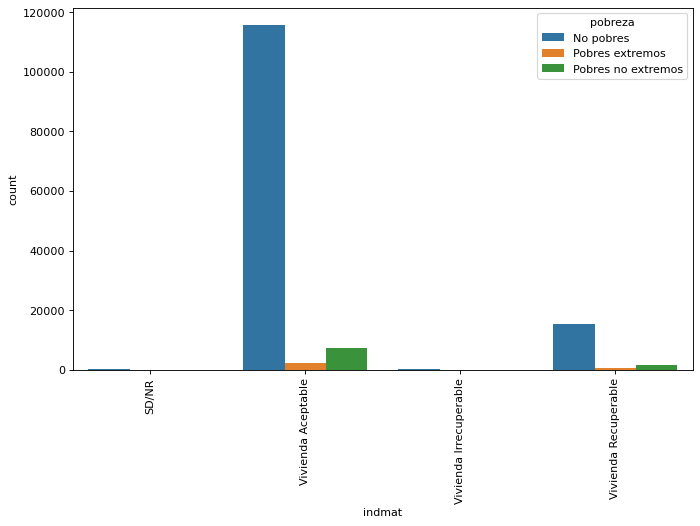

In [18]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="indmat", hue="pobreza", data=df_not_nan)
plt.xticks(rotation=90)
plt.show()

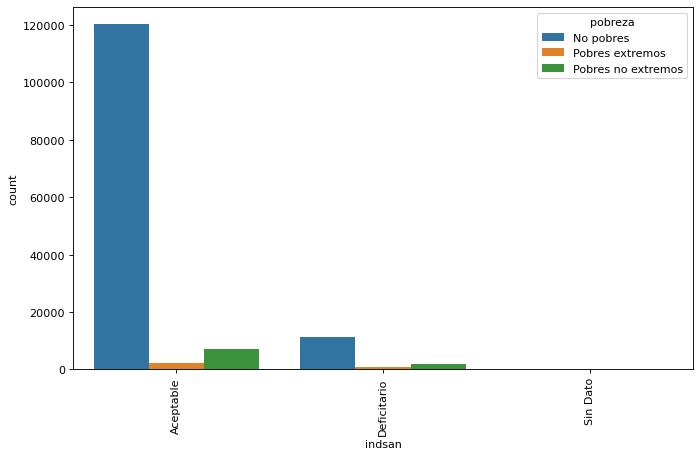

In [19]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="indsan", hue="pobreza", data=df_not_nan)
plt.xticks(rotation=90)
plt.show()

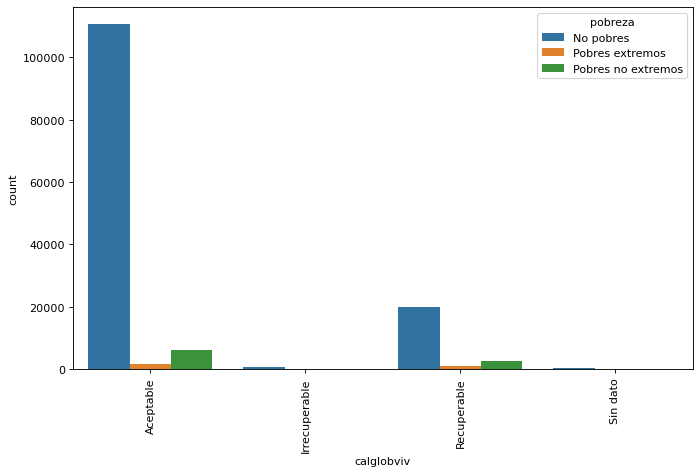

In [20]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="calglobviv", hue="pobreza", data=df_not_nan)
plt.xticks(rotation=90)
plt.show()

---

Considerando las tres dimensiones anteriores podemos ver que al parecer existe una correlación entre sus variables, podríamos confirmar esto con una métrica de similitud como la distancia de Jaccard, pero para no complicar tanto el análisis supondremos que existe una similitud notoria entre las 3 variables y nos quedaremos solo con la variable calglobviv.

---

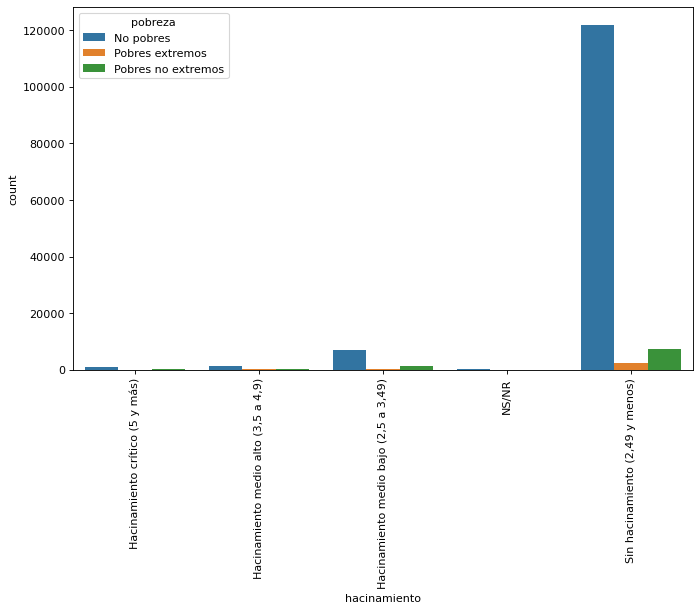

In [21]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="hacinamiento", hue="pobreza", data=df_not_nan)
plt.xticks(rotation=90)
plt.show()

---

A simple vista no se puede establecer un panorama de clasificación de pobreza en la variable hacinamiento, no obstante de igual manera la utilizaremos dada la gran cantidad de no pobres que se encuentra en la categoría Sin hacinamiento.

---

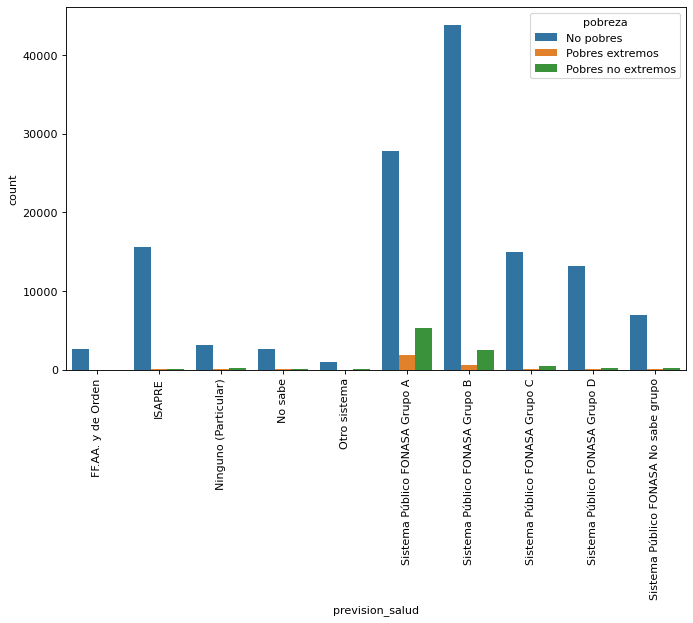

In [22]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="prevision_salud", hue="pobreza", data=df_not_nan)
plt.xticks(rotation=90)
plt.show()

---

De la dimensión previsión salud aparece un insight relevante, el cual muestra que dentro de FONASA A y B se encuentra el grueso de registros clasificados en las categorías de pobreza, por lo que esta variable si nos entregará una varianza importante dentro de la data que utilizaremos para clasificar.

---

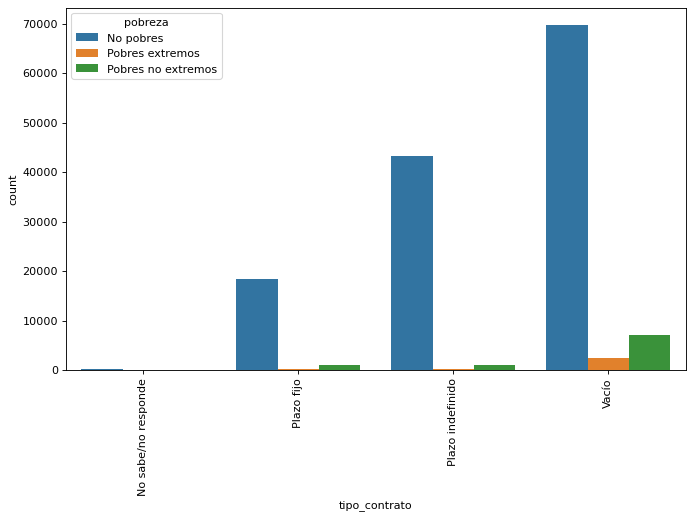

In [23]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="tipo_contrato", hue="pobreza", data=df_not_nan)
plt.xticks(rotation=90)
plt.show()

---

Dentro de quienes respondieron plazo fijo y plazo indefinido no se nota una diferencia marcada en términos absolutos dentro de las categorías de pobreza, no obstante son muchos mas los no pobres de plazo indefinido, por lo que esta variable posiblemente nos servirá a la hora de clasificar.

---

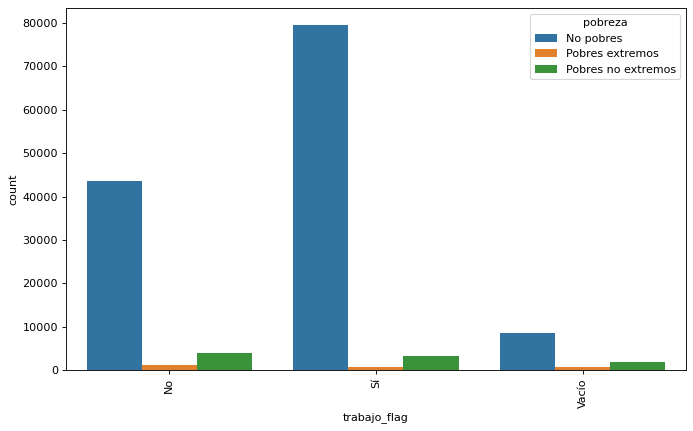

In [24]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="trabajo_flag", hue="pobreza", data=df_not_nan)
plt.xticks(rotation=90)
plt.show()

---

La variable trabajo flag nos muestra que quienes respondieron que no o que traían este campo vacío porcentualmente se encuentran en mayor medida en las categorías de pobreza, por lo que utilizaremos esta variable.

---

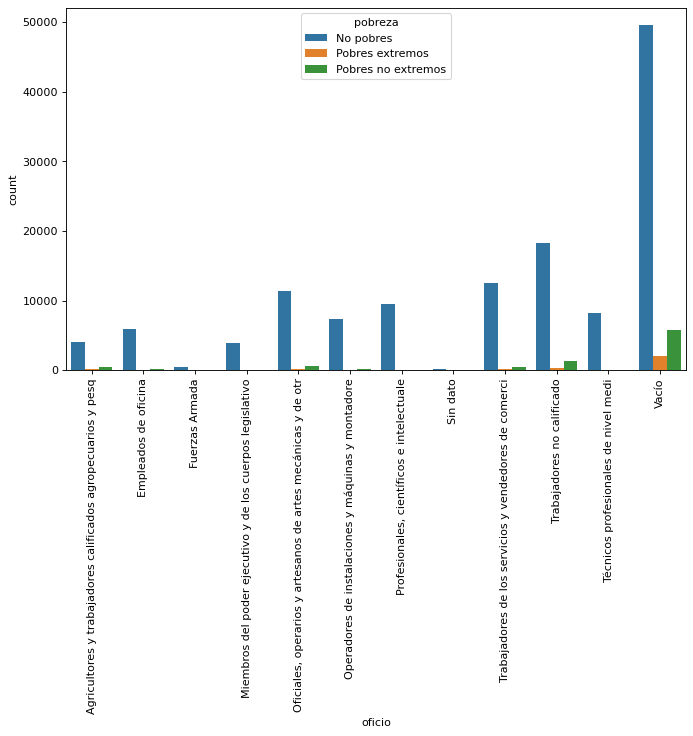

In [25]:
plt.figure(figsize=(10,6), dpi= 80)
sns.countplot(x="oficio", hue="pobreza", data=df_not_nan)
plt.xticks(rotation=90)
plt.show()

---

Si bien muchos registros dentro de la dimensión oficio venían vacíos, las distribuciones de los valores de pobreza para los registros que poseían información paracen tener información suficiente como para decidir utilizar esta variable en los clasificadores.

---

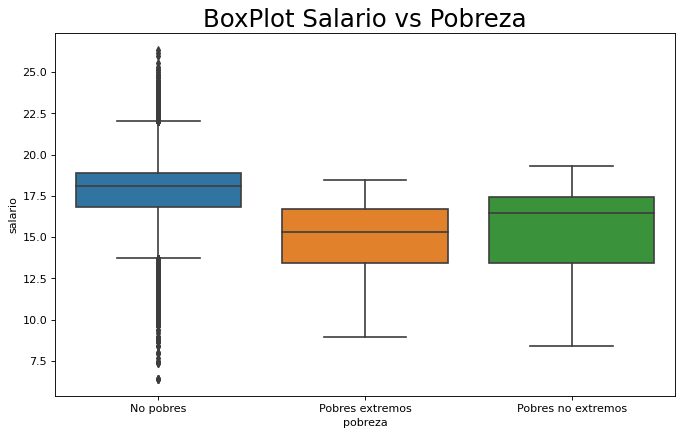

In [26]:
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.boxplot(x='pobreza', y='salario', data=df_not_nan, notch=False)

# Add N Obs inside boxplot (optional)
def add_n_obs(df,group_col,y):
    medians_dict = {grp[0]:grp[1][y].median() for grp in df.groupby(group_col)}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    n_obs = df.groupby(group_col)[y].size().values
    for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
        plt.text(x, medians_dict[xticklabel]*1.01, "#obs : "+str(n_ob), horizontalalignment='center', fontdict={'size':14}, color='white')

# Decoration
plt.title('BoxPlot Salario vs Pobreza', fontsize=22)
plt.show()

---

El salario es una de las variables que nos da un insight mas relevante, dandonos a entender que las categorías de pobreza estan por debajo de los salarios de los no pobres. Si bien hay varios outliers dentro de los no pobres, se tratará de ajustar los modelos de la mejor manera para poder generalizar.

---

Después del análisis exploratorio realizado, se decide utilizar las siguientes variables para los modelos:

 - **Variables Independiente**:
     - *sexo*: Sexo de quien responde la encuesta (Variable categórica)
     - *edad*: Edad de quien responde la encuesta (Variable numérica discreta)
     - *ecivil*: Estado civil de quien responde la encuesta (Variable categórica)
     - *educ*: Escolaridad de quien responde la encuesta (Variable ordinal)
     - *activ*: Categoría de ocupación de quien responde la encuesta (Variable categórica)
     - *calglobviv*: Calidad global de la vivienda de quien responde la encuesta (Variable categórica)
     - *hacinamiento*: Nivel de hacinamiento de la vivienda de quien responde la encuesta (Variable categórica)
     - *s12*: Sistema previsional de salud de quien responde la encuesta (Variable categórica)
     - *o16*: Tipo de contrato de quien responde la encuesta (Variable categórica)
     - *o1*: Flag de trabajo la semana anterior de quien responde la encuesta (Variable categórica)
     - *oficio1*: Ocupación u oficio de quien responde la encuesta (Variable categórica)
     - *ytot*: Salario de quien responde la encuesta (Variable numérica discreta)
     
Además del uso de estas variables, se debe utilizar una técnica de balanceo para que nuestro modelo no caiga en overfitting y podamos generalizarlo. Se utilizará una función class_weigth particular, la cual está basada en el uso de logaritmo, el cual reduce el peso de la clase desbalanceada.
  
Los 3 módelos que se utilizarán son:  

    - Complement Naive-Bayes  
    - Random Forest
    - Decision Tree
    

In [27]:
def pobreza_parse(level):
    aux_dict = {
        'Pobres extremos'                                 : 1,
        'Pobres no extremos'                              : 2,
        'No pobres'                                       : 3
    }
    return aux_dict[level]

In [28]:
df_not_nan['target_pobreza'] = df_not_nan['pobreza'].apply(pobreza_parse)
df_not_nan.dtypes

pobreza              category
sexo                 category
edad                    int64
ecivil               category
educ                 category
depen                category
activ                category
indmat               category
indsan               category
calglobviv           category
hacinamiento         category
prevision_salud      category
tipo_contrato        category
trabajo_flag         category
oficio               category
salario               float64
ordinal_education       int64
target_pobreza       category
dtype: object

In [29]:
# Se definen los predictores y la variable objetivo
features = ["sexo",
            "edad",
            "ecivil",
            "activ",
            "calglobviv",
            "hacinamiento",
            "prevision_salud",
            "tipo_contrato",
            "trabajo_flag",
            "oficio",
            "salario",
            "ordinal_education"]

X_pre_work = df_not_nan[features]
X = pd.get_dummies(X_pre_work, columns=["sexo",
                                        "ecivil",
                                        "activ",
                                        "calglobviv",
                                        "hacinamiento",
                                        "prevision_salud",
                                        "tipo_contrato",
                                        "trabajo_flag",
                                        "oficio"])
y = df_not_nan['target_pobreza']
np_y = y.to_numpy()

In [30]:
# Se asigna un peso a clase desbalanceada

def class_weight(labels_dict,mu=0.15):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    weight = dict()
    for i in keys:
        score = np.log(mu*total/float(labels_dict[i]))
        weight[i] = score if score > 1 else 1
    return weight

labels_dict = df_not_nan['target_pobreza'].value_counts().to_dict()
weights = class_weight(labels_dict)
NB_weight=[weights[i] for i in np_y]

#model = RandomForestClassifier(class_weight = weights)
#model.fit(X,target_Y)

In [33]:
# Se definen los modelos y las métricas a evaluar
models = [ComplementNB(), RandomForestClassifier(class_weight = weights), DecisionTreeClassifier(class_weight = weights)]
names = ["Naive Bayes", "Random Forest", "Decision Tree"]
scorer = MultiScorer({
    'Accuracy'  : (accuracy_score , {}),
    'Precision' : (precision_score, {'pos_label': 3, 'average':'macro'}),
    'Recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'})
})

In [34]:
# Se realiza el método cross-validation para evaluar las métricas
for model, name in zip(models, names):
    print(name)
    start = time.time()

    _ = cross_validate(model, X, y,scoring=scorer, cv=10) 
    results = scorer.get_results()

    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %f' % (metric_name, average_score))

    print('time', time.time() - start, '\n\n')

Naive Bayes
Accuracy : 0.737584
Precision : 0.381906
Recall : 0.463797
time 0.4329824447631836 


Random Forest
Accuracy : 0.821066
Precision : 0.400125
Recall : 0.409896
time 78.41188263893127 


Decision Tree
Accuracy : 0.834418
Precision : 0.396146
Recall : 0.402310
time 5.265597343444824 




---

Dados los resultados obtenidos en las métricas para nuestros modelos, cabe destacar que la métrica de accuracy no es nuestro mejor indicador, ya que a pesar de haber usado un peso para la clase desbalanceada, no fue una estrategia trabajada, podríamos haber realizado un trabajo más exahustivo con un mix entre over-sampling y under-sampling para mejorar robustecer nuestros resultados, pero nos damos cuenta que los altos accuracy se deben a que la gran mayoría de los No pobres fueron bien clasificados. Acá el recall y la precision son importantes, y tenemos una disyuntiva entre si escojer un modelo con mayor recall (Rendimiento con respecto a falsos negativos) o mayor precisión (Rendimiento con respecto a los falsos positivos).  
  
El random forest y el decision tree nos dieron un resultado sobre el 80% en accuracy, no obstante su recall fueron más bajos que el Naive Bayes, por lo cual se descartan estos modelos como nuestra elección. Para este análisis, que tuvo varios supuestos y que no fue muy elaborado en términos de resampleo, nos quedamos con el Naive Bayes. A pesar de que el Naive Bayes tenga menor precision que los otros, no hay una diferencia tan grande como en el recall, por lo que su F-score es superior.

Para un mejor análisis del modelo se podría calcular más granularmente la matriz de confusión asociada a cada categoría del target, no obstante dado el retraso en la entrega prefiero dejar el análisis hasta acá.


---